### Importing some essential libraries

In [12]:
import ipopt
import warnings
import numpy as np
from pyomo.environ import *
import pyomo.environ as pyo
from scipy.io import loadmat
import sklearn
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

### Part A

* Here, we have repeatedly used data shuffling

In [13]:
from sklearn.datasets import make_classification
x, y = make_classification(n_classes=2, n_samples=400, n_features=2,
n_informative=2, n_redundant=0, n_repeated=0, shuffle=False, weights=[0.55,
0.5], random_state=27)
y=y.reshape(400,1)
print(y.shape)
all_matrix = np.hstack((x,y))
print(all_matrix.shape)
np.random.shuffle(all_matrix)


(400, 1)
(400, 3)


In [14]:
y = all_matrix[:,2]
y = y.reshape(-1,)
y_train_new=np.ones(len(y), dtype=int)
y_train_new[y==0]=-1
x = all_matrix[:,0:2]
y = y_train_new

In [15]:
y_train_new

array([ 1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,
       -1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1,
       -1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,
        1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,
       -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,
        1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,
       -1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1,  1,
       -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1,
        1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,
        1,  1,  1,  1,  1

In [16]:
x

array([[-1.41394881,  1.8485587 ],
       [-0.53542377,  2.61157727],
       [-1.71438484,  1.22722475],
       [-0.14845641, -1.41043548],
       [-1.3356209 ,  0.73220157],
       [ 2.59236019,  0.46157434],
       [ 0.22514428,  1.16704846],
       [ 0.7007176 , -2.49987221],
       [-0.44256663, -0.59515165],
       [ 1.82025489,  1.19451586],
       [-0.74823747,  1.5098228 ],
       [-0.11786516,  0.85597864],
       [ 0.38056561, -2.02345236],
       [ 1.46945298,  1.07168011],
       [-0.76364991,  1.22542821],
       [-1.3040855 , -0.00733276],
       [ 0.8171618 , -0.77600963],
       [ 1.67438712,  0.30219901],
       [ 3.53982246,  0.13984236],
       [-0.61650867,  1.02121433],
       [-0.11418843,  0.76857353],
       [-1.01479263,  2.11183529],
       [-0.58244837, -2.16374665],
       [-1.28588209,  0.56901173],
       [-1.66780596,  0.16279398],
       [-0.11417121, -1.35324756],
       [ 2.08699389, -0.39897242],
       [-1.82601195, -0.34781243],
       [ 1.98461579,

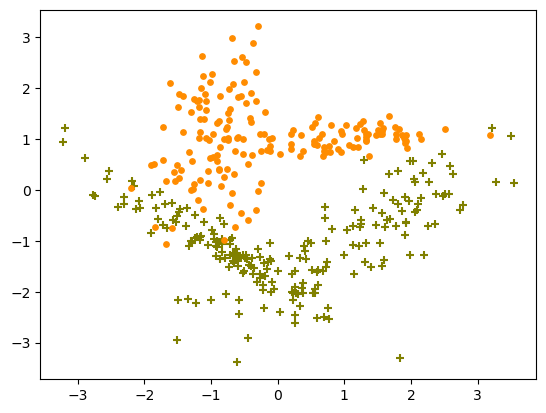

In [17]:
plt.scatter(x[y_train_new==-1,0], x[y_train_new==-1, 1],color='olive', marker='+' ,edgecolors='orange',s=30)
plt.scatter(x[y_train_new==1,0], x[y_train_new==1, 1],color='darkorange', marker='o',s=15)

### Part B

In [18]:
from sklearn.model_selection import train_test_split
all_data_x = x
all_data_y = y_train_new
x_300,x_100,y_300,y_100=train_test_split(x, y_train_new, test_size=0.25, shuffle=True, stratify=y, random_state=1)
default_x = x_300
default_y = y_300

### Part C

### C - 1) Decision boundary with meshgrid

In [6]:
def ipopt_solver_handler_part_c(x_trian_values ,y_train_values,c_value,sigma_value,message):
    def kernel(x,xp,sigma):
        return np.exp(-np.sum((x-xp)**2)/(2*sigma**2))

    sigma = sigma_value
    x_train = x_trian_values
    y_train = y_train_values
    
    gram = np.zeros((len(y_train), len(y_train)))
    for i in range(len(y_train)):
        for ip in range(len(y_train)):
            gram[i,ip]=kernel(x_train[i,:], x_train[ip,:], sigma)

    data_x={(i+1,j+1):x_train[i ,j] for i in range(0, len(y_train)) for j in range(0, x_train.shape[1])}
    data_y={i+1:y_train[i] for i in range(0, len(y_train))}
    dgmodel=pyo.ConcreteModel()
    dgmodel.iset=pyo.Set(initialize=range(1, len(y_train)+1))
    dgmodel.jset=pyo.Set(initialize=range(1,x_train.shape[1]+1))
    dgmodel.x=pyo.Param(dgmodel.iset, dgmodel.jset, initialize=data_x)
    dgmodel.y=pyo.Param(dgmodel.iset, initialize=data_y)
    dgmodel.C=pyo.Param(initialize=1, mutable=True)
    dgmodel.alpha=pyo.Var(dgmodel.iset, domain=pyo.NonNegativeReals)
    def dgobj_rule(dgmodel):
        return sum(dgmodel.alpha[i] for i in dgmodel.iset)\
    -0.5*sum(dgmodel.alpha[i]*dgmodel.alpha[ip]*dgmodel.y[i]*dgmodel.y[ip]*gram[i-1,ip-1] for i in dgmodel.iset for ip in dgmodel.iset)
    dgmodel.obj=pyo.Objective(rule=dgobj_rule, sense=pyo.maximize)
    def dgconst1_rule(dgmodel):
        return sum(dgmodel.alpha[i]*dgmodel.y[i] for i in dgmodel.iset)==0
    dgmodel.const1=pyo.Constraint(rule=dgconst1_rule)
    def dgconst2_rule(dgmodel, i):
        return dgmodel.alpha[i]<=dgmodel.C
    dgmodel.const2=pyo.Constraint(dgmodel.iset, rule=dgconst2_rule)
    dgresult = pyo.SolverFactory('ipopt',
                          executable = r"C:\Users\mmmoh\Desktop\Ipopt-3.5.4-win64-icl9.0\Ipopt-3.5.4-win64-icl9.0\bin\ipopt")
    dgresult.solve(dgmodel)
    optimal_alpha_vector=np.array([pyo.value(dgmodel.alpha[i]) for i in dgmodel.iset])
    for i in range(0, len(optimal_alpha_vector)):
        if optimal_alpha_vector[i]>0 and  optimal_alpha_vector[i]<pyo.value(dgmodel.C):
            selected_i=i
            break
    fig1, ax1=plt.subplots()
    w0=y_train[selected_i]-sum(optimal_alpha_vector[i]*y_train[i]*kernel(x_train[i,:], x_train[selected_i,:],sigma) for i in range(len(y_train)))
    x1=np.linspace(-4,4,100)
    x2=np.linspace(-4,4,100)
    x1_mesh,x2_mesh=np.meshgrid(x1, x2)
    z_mesh=np.zeros(x1_mesh.shape)
    for r in range(z_mesh.shape[0]):
        for c in range(z_mesh.shape[1]):
            xhat=np.array([x1_mesh[r,c], x2_mesh[r,c]])
            z_mesh[r,c]=sum(optimal_alpha_vector[i]*y_train[i]*kernel(xhat,x_train[i,:],sigma) for i in range(len(y_train)))+w0
    ax1.contour(x1_mesh, x2_mesh,z_mesh,[0])
    ax1.scatter(x_train[y_train==1, 0], x_train[y_train==1, 1], color='darkorange', marker='o',s=8)
    ax1.scatter(x_train[y_train==-1, 0], x_train[y_train==-1, 1], color='olive', marker='+')
    plt.title(message)


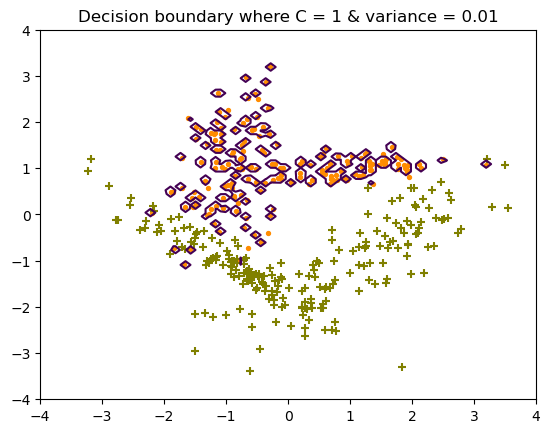

In [31]:
ipopt_solver_handler_part_c(all_data_x ,all_data_y,1,0.01,"Decision boundary where C = 1 & variance = 0.01")

### C - 2) Decision boundary with plot_decision_regions

#### here variance should be 0.01 so according to the gamma with below formula:
#### gamma = 1/(2 *variance^2) 
#### when variance the variance is 0.01, gamma should be 5000

[]

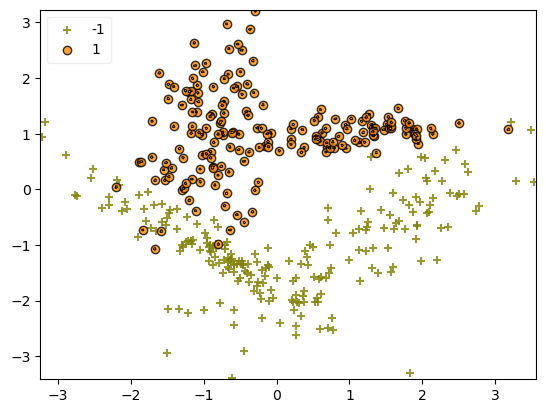

In [358]:
svc = sklearn.svm.SVC(kernel = 'rbf', C = 1 , gamma = 5000)
svc.fit(all_data_x, all_data_y)
markers_st = ["+", "o"]
scatter_highlight_kwargs = {'alpha': 5.5,'edgecolor':'black'}
ax = plot_decision_regions( all_data_x, all_data_y,
                           clf=svc,
                           colors='olive,darkorange',
                           zoom_factor = 40,
                           markers = markers_st,
                           hide_spines=False,
                           legend=2,
                           scatter_highlight_kwargs=scatter_highlight_kwargs)
ax.set_facecolor("white")
ax.plot()

#### Decision boundaries are not exactly the same and there was some inconsistencies between meshgrid approach and plot_decision_regions approach , but they have treated the problem in the same with sigma = 0.01 and c =1


### Part D

In [85]:
def kernel(x,xp,sigma):
    return np.exp(-np.sum((x-xp)**2)/(2*sigma**2))

def ipopt_solver_handler_with_evaluation(x_trian_values,y_train_values,
                                         x_test_values,y_test_values,c_value,sigma_value):
    
    x_train = x_trian_values
    y_train = y_train_values
    x_test = x_test_values
    y_test = y_test_values
    sigma = sigma_value
    
    gram=np.zeros((len(y_train), len(y_train)))
    for i in range(len(y_train)):
        for ip in range(len(y_train)):
            gram[i,ip]=kernel(x_train[i,:], x_train[ip,:], sigma)
    data_x={(i+1,j+1):x_train[i ,j] for i in range(0, len(y_train)) for j in range(0, x_train.shape[1])}
    data_y={i+1:y_train[i] for i in range(0, len(y_train))}
    dgmodel=pyo.ConcreteModel()
    dgmodel.iset=pyo.Set(initialize=range(1, len(y_train)+1))
    dgmodel.jset=pyo.Set(initialize=range(1,x_train.shape[1]+1))
    dgmodel.x=pyo.Param(dgmodel.iset, dgmodel.jset, initialize=data_x)
    dgmodel.y=pyo.Param(dgmodel.iset, initialize=data_y)
    dgmodel.C=pyo.Param(initialize = c_value, mutable = True)
    dgmodel.alpha=pyo.Var(dgmodel.iset, domain=pyo.NonNegativeReals)
    def dgobj_rule(dgmodel):
        return sum(dgmodel.alpha[i] for i in dgmodel.iset)\
    -0.5*sum(dgmodel.alpha[i]*dgmodel.alpha[ip]*dgmodel.y[i]*dgmodel.y[ip]*gram[i-1,ip-1] for i in dgmodel.iset for ip in dgmodel.iset)
    dgmodel.obj=pyo.Objective(rule=dgobj_rule, sense=pyo.maximize)
    def dgconst1_rule(dgmodel):
        return sum(dgmodel.alpha[i]*dgmodel.y[i] for i in dgmodel.iset)==0
    dgmodel.const1=pyo.Constraint(rule=dgconst1_rule)
    def dgconst2_rule(dgmodel, i):
        return dgmodel.alpha[i]<=dgmodel.C
    dgmodel.const2=pyo.Constraint(dgmodel.iset, rule=dgconst2_rule)
    dgresult = pyo.SolverFactory('ipopt',
                          executable = r"C:\Users\mmmoh\Desktop\Ipopt-3.5.4-win64-icl9.0\Ipopt-3.5.4-win64-icl9.0\bin\ipopt")
    dgresult.solve(dgmodel)
    optimal_alpha_vector = np.array([pyo.value(dgmodel.alpha[i]) for i in dgmodel.iset])
    for i in range(0, len(optimal_alpha_vector)):
        if optimal_alpha_vector[i]>0 and  optimal_alpha_vector[i]<pyo.value(dgmodel.C):
            selected_i=i
            break
    w0=y_train[selected_i]-sum(optimal_alpha_vector[i]*y_train[i]*kernel(
        x_train[i,:], x_train[selected_i,:],sigma) for i in range(len(y_train)))  
    
    yhats_list = []
    for i in range(0, len(y_test)):
        xhat=np.array(x_test[i,:])
        yhat=np.sign(np.array(sum(optimal_alpha_vector[j]*y_train[j]*kernel(
            xhat, x_train[j,:], sigma) for j in range(len(y_train)))+w0))
        yhats_list.append(yhat) 
    tp,fn,fp,tn=[],[],[],[]
    for i in range(len(y_test)):
        if yhats_list[i]==1 and y_test[i]==1:
            tp.append(yhats_list[i])
        if yhats_list[i]==1 and y_test[i]==-1:
            fp.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==1:
            fn.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==-1:
            tn.append(yhats_list[i])
    if len(tp) == 0 and len(fp) == 0:
        per = 0
        rec = 0
        F1_score = 0
    else:
        per = ((len(tp)) / (len(tp) + len(fp)))
        rec = ((len(tp)) / (len(tp) + len(fn)))
        F1_score = 2*per*rec/(per + rec)
    acc = (len(tp)+len(tn))/(len(tp)+len(tn)+len(fn)+len(fp))
    print("____________________________________________________________")
    print("Performance evaluation from scratch: ")
    print("____________________________________________________________")
    print("True positive rate: ",len(tp) )
    print("True negative rate: ",len(tn) )
    print("False positive rate: ",len(fp) )
    print("False negative rate: ",len(fn) )
    print("_______________________________________")
    print("Accuracy: ", acc)
    print("Recall: ", rec)
    print("precision: ", per)
    print("F1_Score: ",F1_score )
    print("____________________________________________________________")
    return yhats_list

### Performance evaluation for only train dataset

In [360]:

output = ipopt_solver_handler_with_evaluation(x_300,y_300,x_300,y_300,1,0.01)
y_pred = np.array(output)
print("Performance evaluation based on sklearn.metrics: ")
print("____________________________________________________________")
print("Accuracy: ",accuracy_score(y_300, y_pred))
print("Recall: ",recall_score(y_300, y_pred, average="macro"))
print("Precision: ",precision_score(y_300, y_pred, average="macro"))
print("F1_score: ",f1_score(y_300, y_pred, average="macro"))
confusion = confusion_matrix(y_300, y_pred)
print("_______________________________________")
print("confusion_matrix:")
print(confusion)


____________________________________________________________
Performance evaluation from scratch: 
____________________________________________________________
True positive rate:  135
True negative rate:  165
False positive rate:  0
False negative rate:  0
_______________________________________
Accuracy:  1.0
Recall:  1.0
precision:  1.0
F1_Score:  1.0
____________________________________________________________
Performance evaluation based on sklearn.metrics: 
____________________________________________________________
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
F1_score:  1.0
_______________________________________
confusion_matrix:
[[165   0]
 [  0 135]]


### Performance evaluation for only test dataset

In [361]:
output = ipopt_solver_handler_with_evaluation(x_300,y_300,x_100,y_100,1,0.01)
y_pred = np.array(output)
print("Performance evaluation based on sklearn.metrics: ")
print("____________________________________________________________")
print("Accuracy: ",accuracy_score(y_100, y_pred))
print("Recall: ",recall_score(y_100, y_pred,))
print("Precision: ",precision_score(y_100, y_pred))
print("F1_score: ",f1_score(y_100, y_pred))
confusion = confusion_matrix(y_100, y_pred)
print("_______________________________________")
print("confusion_matrix:")
print(confusion)

____________________________________________________________
Performance evaluation from scratch: 
____________________________________________________________
True positive rate:  45
True negative rate:  16
False positive rate:  39
False negative rate:  0
_______________________________________
Accuracy:  0.61
Recall:  1.0
precision:  0.5357142857142857
F1_Score:  0.6976744186046512
____________________________________________________________
Performance evaluation based on sklearn.metrics: 
____________________________________________________________
Accuracy:  0.61
Recall:  1.0
Precision:  0.5357142857142857
F1_score:  0.6976744186046512
_______________________________________
confusion_matrix:
[[16 39]
 [ 0 45]]


### Performance evaluation for all dataset (train + test)

In [362]:
output = ipopt_solver_handler_with_evaluation(x_300,y_300,all_data_x,all_data_y,1,0.01)
y_pred = np.array(output)
print("Performance evaluation based on sklearn.metrics: ")
print("____________________________________________________________")
print("Accuracy: ",accuracy_score(all_data_y, y_pred))
print("Recall: ",recall_score(all_data_y, y_pred,))
print("Precision: ",precision_score(all_data_y, y_pred))
print("F1_score: ",f1_score(all_data_y, y_pred))
confusion = confusion_matrix(all_data_y, y_pred)
print("_______________________________________")


____________________________________________________________
Performance evaluation from scratch: 
____________________________________________________________
True positive rate:  180
True negative rate:  181
False positive rate:  39
False negative rate:  0
_______________________________________
Accuracy:  0.9025
Recall:  1.0
precision:  0.821917808219178
F1_Score:  0.9022556390977443
____________________________________________________________
Performance evaluation based on sklearn.metrics: 
____________________________________________________________
Accuracy:  0.9025
Recall:  1.0
Precision:  0.821917808219178
F1_score:  0.9022556390977443
_______________________________________


### All metrics are exactly the same.

### Part E

In [363]:
def kernel(x,xp,sigma):
    return np.exp(-np.sum((x-xp)**2)/(2*sigma**2))

def ipopt_solver_handler(x_trian_values,y_train_values,
                                         x_test_values,y_test_values,c_value,sigma_value):
    
    x_trian = x_trian_values
    y_train = y_train_values
    x_test = x_test_values
    y_test = y_test_values
    sigma = sigma_value
    
    gram=np.zeros((len(y_train), len(y_train)))
    for i in range(len(y_train)):
        for ip in range(len(y_train)):
            gram[i,ip]=kernel(x_train[i,:], x_train[ip,:], sigma)
    data_x={(i+1,j+1):x_train[i ,j] for i in range(0, len(y_train)) for j in range(0, x_train.shape[1])}
    data_y={i+1:y_train[i] for i in range(0, len(y_train))}
    dgmodel=pyo.ConcreteModel()
    dgmodel.iset=pyo.Set(initialize=range(1, len(y_train)+1))
    dgmodel.jset=pyo.Set(initialize=range(1,x_train.shape[1]+1))
    dgmodel.x=pyo.Param(dgmodel.iset, dgmodel.jset, initialize=data_x)
    dgmodel.y=pyo.Param(dgmodel.iset, initialize=data_y)
    dgmodel.C=pyo.Param(initialize = c_value, mutable = True)
    dgmodel.alpha=pyo.Var(dgmodel.iset, domain=pyo.NonNegativeReals)
    def dgobj_rule(dgmodel):
        return sum(dgmodel.alpha[i] for i in dgmodel.iset)\
    -0.5*sum(dgmodel.alpha[i]*dgmodel.alpha[ip]*dgmodel.y[i]*dgmodel.y[ip]*gram[i-1,ip-1] for i in dgmodel.iset for ip in dgmodel.iset)
    dgmodel.obj=pyo.Objective(rule=dgobj_rule, sense=pyo.maximize)
    def dgconst1_rule(dgmodel):
        return sum(dgmodel.alpha[i]*dgmodel.y[i] for i in dgmodel.iset)==0
    dgmodel.const1=pyo.Constraint(rule=dgconst1_rule)
    def dgconst2_rule(dgmodel, i):
        return dgmodel.alpha[i]<=dgmodel.C
    dgmodel.const2=pyo.Constraint(dgmodel.iset, rule=dgconst2_rule)
    dgresult = pyo.SolverFactory('ipopt',
                          executable = r"C:\Users\mmmoh\Desktop\Ipopt-3.5.4-win64-icl9.0\Ipopt-3.5.4-win64-icl9.0\bin\ipopt")
    dgresult.solve(dgmodel)
    optimal_alpha_vector = np.array([pyo.value(dgmodel.alpha[i]) for i in dgmodel.iset])
    for i in range(0, len(optimal_alpha_vector)):
        if optimal_alpha_vector[i]>0 and  optimal_alpha_vector[i]<pyo.value(dgmodel.C):
            selected_i=i
            break
    w0=y_train[selected_i]-sum(optimal_alpha_vector[i]*y_train[i]*kernel(
        x_train[i,:], x_train[selected_i,:],sigma) for i in range(len(y_train)))  
    
    yhats_list = []
    for i in range(0, len(y_test)):
        xhat=np.array(x_test[i,:])
        yhat=np.sign(np.array(sum(optimal_alpha_vector[j]*y_train[j]*kernel(
            xhat, x_train[j,:], sigma) for j in range(len(y_train)))+w0))
        yhats_list.append(yhat) 
    tp,fn,fp,tn=[],[],[],[]
    for i in range(len(y_test)):
        if yhats_list[i]==1 and y_test[i]==1:
            tp.append(yhats_list[i])
        if yhats_list[i]==1 and y_test[i]==-1:
            fp.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==1:
            fn.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==-1:
            tn.append(yhats_list[i])
    if len(tp) == 0 and len(fp) == 0:
        per = 0
        rec = 0
        F1_score = 0
    else:
        per = ((len(tp)) / (len(tp) + len(fp)))
        rec = ((len(tp)) / (len(tp) + len(fn)))
        F1_score = 2*per*rec/(per + rec)
    acc = (len(tp)+len(tn))/(len(tp)+len(tn)+len(fn)+len(fp))
    return pyo.value(dgmodel.obj),F1_score

### Folds preview

* In part A, we have repeatedly used data shuffling 
* so that's why there is no need to shuffle before dividing the folds
#### To implement 5 fold cross_validation, we could have used the relevant libraries or using repeatedly train_test_split would have been more suitable, but according to the use of np.shuffle, the following method was chosen 

In [364]:
y_300 = y_300.reshape(300,1)
all_matrix = np.hstack((x_300,y_300))
F1 = all_matrix[0:60,:]
F2 = all_matrix[60:120,:]
F3 = all_matrix[120:180,:]
F4 = all_matrix[180:240,:]
F5 = all_matrix[240:300,:]
print("Fold 1: ", F1.shape)
print("Fold 2: ", F2.shape)
print("Fold 3: ", F3.shape)
print("Fold 4: ", F4.shape)
print("Fold 5: ", F5.shape)
c_array = [0.01,0.1,1,10,100]
variance_array = [0.01,0.1,1,10,100]

Fold 1:  (60, 3)
Fold 2:  (60, 3)
Fold 3:  (60, 3)
Fold 4:  (60, 3)
Fold 5:  (60, 3)


### k fold cross validation for all 25 permutation

In [379]:
result_list_ipopt = []
for c_value in c_array:
    for variance_value in variance_array:
        print("Current c and variance is: ",c_value,variance_value )
        #_____________________________________
        # K1 is test and K2-K3-K4-K5 is train set
        train_set = all_matrix[60:,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[0:60,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        first_obj,first_F1 = ipopt_solver_handler(x_train,y_train,x_test,y_test,c_value,variance_value)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K2 is test and K1-K3-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:60,:],all_matrix[120:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[60:120,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        second_obj,second_F1 = ipopt_solver_handler(x_train,y_train,x_test,y_test,c_value,variance_value)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K3 is test and K1-K2-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:120,:],all_matrix[180:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[120:180,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        third_obj,third_F1 = ipopt_solver_handler(x_train,y_train,x_test,y_test,c_value,variance_value)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K4 is test and K1-K2-K3-K5 is train set
        train_set = np.vstack((all_matrix[0:180,:],all_matrix[240:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[180:240,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        fourth_obj,fourth_F1 = ipopt_solver_handler(x_train,y_train,x_test,y_test,c_value,
                                                    variance_value)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K5 is test and K1-K2-K3-K4 is train set
        train_set = all_matrix[0:240,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[240:300,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        fifth_obj,fifth_F1 = ipopt_solver_handler(x_train,y_train,x_test,y_test,c_value,variance_value)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        F1_avg = (first_F1 + second_F1 + third_F1 + fourth_F1 + fifth_F1)/5
        obj_avg = (first_obj + second_obj + third_obj + fourth_obj + fifth_obj)/5
        print("F1_Score: ",F1_avg,"Objective function:",obj_avg)
        print("___________________________")
        result_list_ipopt.append((c_value,variance_value,F1_avg,obj_avg))
len(result_list_ipopt)

Current c and variance is:  0.01 0.01
F1_Score:  0.0 Objective function: 2.1501180353362925
___________________________
Current c and variance is:  0.01 0.1
F1_Score:  0.0 Objective function: 2.141199254133095
___________________________
Current c and variance is:  0.01 1
F1_Score:  0.0 Objective function: 1.8976572285885276
___________________________
Current c and variance is:  0.01 10
F1_Score:  0.0 Objective function: 2.1428176945217503
___________________________
Current c and variance is:  0.01 100
F1_Score:  0.0 Objective function: 2.1598248557652036
___________________________
Current c and variance is:  0.1 0.01
F1_Score:  0.0 Objective function: 20.611618266787836
___________________________
Current c and variance is:  0.1 0.1
F1_Score:  0.0 Objective function: 19.719765410393432
___________________________
Current c and variance is:  0.1 1
F1_Score:  0.9523877151127614 Objective function: 7.991401310071612
___________________________
Current c and variance is:  0.1 10
F1_Sco

25

#### Sorting result based on F1_score

In [385]:
result_list_ipopt.sort(key = lambda i: i[2],reverse=True)
# print(result_list_ipopt)
for i in range(len(result_list)):
    print(
        f'{i+1}- where C is {result_list_ipopt[i][0]} & sigma is {result_list_ipopt[i][1]} : F1_score is {result_list_ipopt[i][2]} and Obj Avg is {result_list_ipopt[i][3]} ')
    print("______________________________")

1- where C is 100 & sigma is 1 : F1_score is 0.967343372728428 and Obj Avg is 927.7498275665163 
______________________________
2- where C is 10 & sigma is 1 : F1_score is 0.9633699144926748 and Obj Avg is 155.6724728578738 
______________________________
3- where C is 1 & sigma is 1 : F1_score is 0.9617741039177549 and Obj Avg is 30.71761574697688 
______________________________
4- where C is 0.1 & sigma is 1 : F1_score is 0.9523877151127614 and Obj Avg is 7.991401310071612 
______________________________
5- where C is 100 & sigma is 10 : F1_score is 0.9485759729608828 and Obj Avg is 3806.7969027551126 
______________________________
6- where C is 10 & sigma is 10 : F1_score is 0.927781397244367 and Obj Avg is 608.4072069620365 
______________________________
7- where C is 10 & sigma is 0.1 : F1_score is 0.9012205622697186 and Obj Avg is 85.84478797860095 
______________________________
8- where C is 1 & sigma is 0.1 : F1_score is 0.8996499407025723 and Obj Avg is 73.28653584514953 
_

In [19]:

def ipopt_solver_handler_train_only(x_trian_values ,y_train_values,c_value,sigma_value,message,all_data_x,all_data_y):
    def kernel(x,xp,sigma):
        return np.exp(-np.sum((x-xp)**2)/(2*sigma**2))

    sigma = sigma_value
    x_train = x_trian_values
    y_train = y_train_values
    
    gram = np.zeros((len(y_train), len(y_train)))
    for i in range(len(y_train)):
        for ip in range(len(y_train)):
            gram[i,ip]=kernel(x_train[i,:], x_train[ip,:], sigma)

    data_x={(i+1,j+1):x_train[i ,j] for i in range(0, len(y_train)) for j in range(0, x_train.shape[1])}
    data_y={i+1:y_train[i] for i in range(0, len(y_train))}
    dgmodel=pyo.ConcreteModel()
    dgmodel.iset=pyo.Set(initialize=range(1, len(y_train)+1))
    dgmodel.jset=pyo.Set(initialize=range(1,x_train.shape[1]+1))
    dgmodel.x=pyo.Param(dgmodel.iset, dgmodel.jset, initialize=data_x)
    dgmodel.y=pyo.Param(dgmodel.iset, initialize=data_y)
    dgmodel.C=pyo.Param(initialize=1, mutable=True)
    dgmodel.alpha=pyo.Var(dgmodel.iset, domain=pyo.NonNegativeReals)
    def dgobj_rule(dgmodel):
        return sum(dgmodel.alpha[i] for i in dgmodel.iset)\
    -0.5*sum(dgmodel.alpha[i]*dgmodel.alpha[ip]*dgmodel.y[i]*dgmodel.y[ip]*gram[i-1,ip-1] for i in dgmodel.iset for ip in dgmodel.iset)
    dgmodel.obj=pyo.Objective(rule=dgobj_rule, sense=pyo.maximize)
    def dgconst1_rule(dgmodel):
        return sum(dgmodel.alpha[i]*dgmodel.y[i] for i in dgmodel.iset)==0
    dgmodel.const1=pyo.Constraint(rule=dgconst1_rule)
    def dgconst2_rule(dgmodel, i):
        return dgmodel.alpha[i]<=dgmodel.C
    dgmodel.const2=pyo.Constraint(dgmodel.iset, rule=dgconst2_rule)
    dgresult = pyo.SolverFactory('ipopt',
                          executable = r"C:\Users\mmmoh\Desktop\Ipopt-3.5.4-win64-icl9.0\Ipopt-3.5.4-win64-icl9.0\bin\ipopt")
    dgresult.solve(dgmodel)
    optimal_alpha_vector=np.array([pyo.value(dgmodel.alpha[i]) for i in dgmodel.iset])
    for i in range(0, len(optimal_alpha_vector)):
        if optimal_alpha_vector[i]>0 and  optimal_alpha_vector[i]<pyo.value(dgmodel.C):
            selected_i=i
            break
    fig1, ax1=plt.subplots()
    w0=y_train[selected_i]-sum(optimal_alpha_vector[i]*y_train[i]*kernel(x_train[i,:], x_train[selected_i,:],sigma) for i in range(len(y_train)))
    x1=np.linspace(-4,4,100)
    x2=np.linspace(-4,4,100)
    x1_mesh,x2_mesh=np.meshgrid(x1, x2)
    z_mesh=np.zeros(x1_mesh.shape)
    for r in range(z_mesh.shape[0]):
        for c in range(z_mesh.shape[1]):
            xhat=np.array([x1_mesh[r,c], x2_mesh[r,c]])
            z_mesh[r,c]=sum(optimal_alpha_vector[i]*y_train[i]*kernel(xhat,x_train[i,:],sigma) for i in range(len(y_train)))+w0
    ax1.contour(x1_mesh, x2_mesh,z_mesh,[0])
    ax1.scatter(all_data_x[all_data_y==1, 0], all_data_x[all_data_y==1, 1], color='darkorange', marker='o',s=8)
    ax1.scatter(all_data_x[all_data_y==-1, 0], all_data_x[all_data_y==-1, 1], color='olive', marker='+')
    plt.title(message)


### Part F

### It is obvious that F1-score should not be considered individually and the objective function value should also be considered for choosing the best hyper-parameters.

### The best result belongs to 
### c =1 & variance = 1 where F1_score = 0.96 and Objective_Avg is 30.71

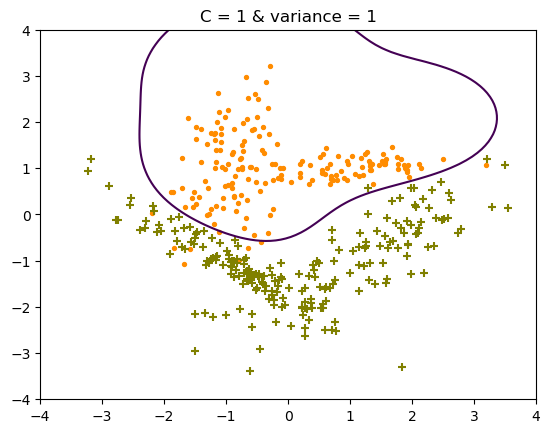

In [9]:
ipopt_solver_handler_train_only(default_x,default_y,1,1,"C = 1 & variance = 1",all_data_x,all_data_y)

### Check other answers ...
#### There was some other condition and models with high F1_score which could be suitable but they are not recommended because of overfitting or high objective function value

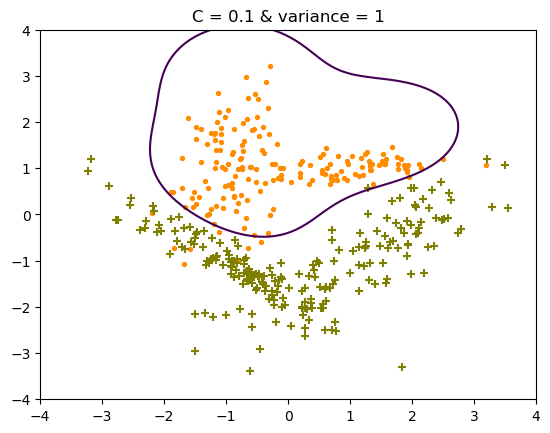

In [21]:
ipopt_solver_handler_train_only(default_x,default_y,0.1,1,"C = 0.1 & variance = 1",all_data_x,all_data_y) 

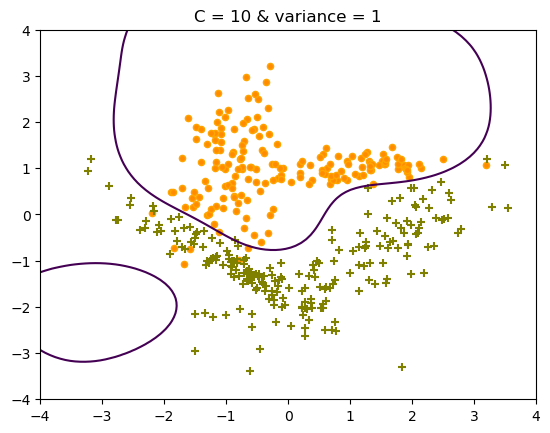

In [368]:
ipopt_solver_handler_train_only(default_x,default_y,10,1,"C = 10 & variance = 1",all_data_x,all_data_y)

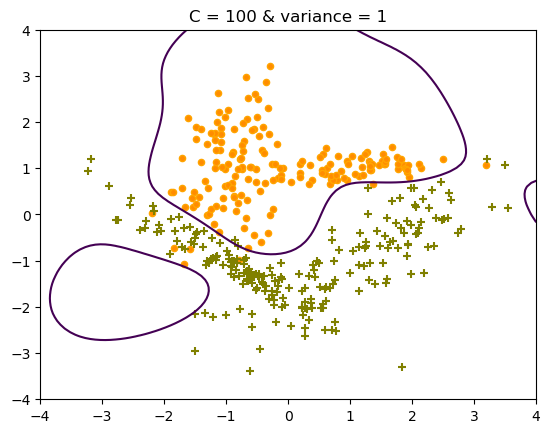

In [369]:
ipopt_solver_handler_train_only(default_x,default_y,100,1,"C = 100 & variance = 1",all_data_x,all_data_y)

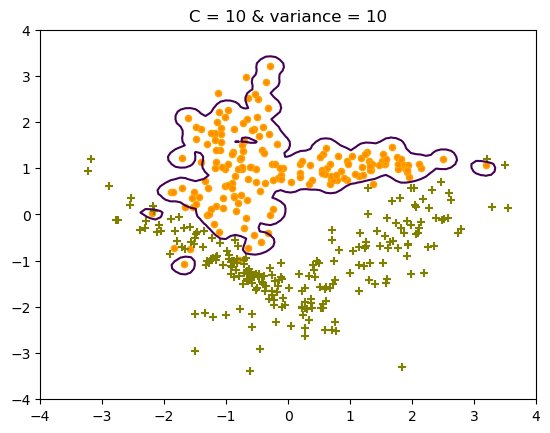

In [370]:
ipopt_solver_handler_train_only(default_x,default_y,10,10,"C = 10 & variance = 10",all_data_x,all_data_y)

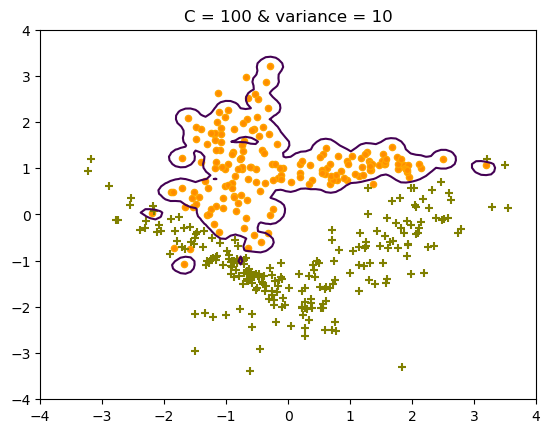

In [371]:
ipopt_solver_handler_train_only(default_x,default_y,100,10,"C = 100 & variance = 10",all_data_x,all_data_y)

### Part g

### ipopt_solver_handler manipulation for using sigmoid to predict labels

In [81]:
def kernel(x,xp,sigma):
    return np.exp(-np.sum((x-xp)**2)/(2*sigma**2))

def ipopt_solver_handler_sigmoid(x_trian_values , y_train_values,x_test_values,y_test_values,
                         c_value,sigma_value):
    x_train = x_trian_values
    y_train = y_train_values
    x_test = x_test_values
    y_test = y_test_values
    sigma = sigma_value
    
    gram=np.zeros((len(y_train), len(y_train)))
    for i in range(len(y_train)):
        for ip in range(len(y_train)):
            gram[i,ip]=kernel(x_train[i,:], x_train[ip,:], sigma)
    data_x={(i+1,j+1):x_train[i ,j] for i in range(0, len(y_train)) for j in range(0, x_train.shape[1])}
    data_y={i+1:y_train[i] for i in range(0, len(y_train))}
    dgmodel=pyo.ConcreteModel()
    dgmodel.iset=pyo.Set(initialize=range(1, len(y_train)+1))
    dgmodel.jset=pyo.Set(initialize=range(1,x_train.shape[1]+1))
    dgmodel.x=pyo.Param(dgmodel.iset, dgmodel.jset, initialize=data_x)
    dgmodel.y=pyo.Param(dgmodel.iset, initialize=data_y)
    dgmodel.C=pyo.Param(initialize = c_value, mutable = True)
    dgmodel.alpha=pyo.Var(dgmodel.iset, domain=pyo.NonNegativeReals)
    def dgobj_rule(dgmodel):
        return sum(dgmodel.alpha[i] for i in dgmodel.iset)\
    -0.5*sum(dgmodel.alpha[i]*dgmodel.alpha[ip]*dgmodel.y[i]*dgmodel.y[ip]*gram[i-1,ip-1] for i in dgmodel.iset for ip in dgmodel.iset)
    dgmodel.obj=pyo.Objective(rule=dgobj_rule, sense=pyo.maximize)
    def dgconst1_rule(dgmodel):
        return sum(dgmodel.alpha[i]*dgmodel.y[i] for i in dgmodel.iset)==0
    dgmodel.const1=pyo.Constraint(rule=dgconst1_rule)
    def dgconst2_rule(dgmodel, i):
        return dgmodel.alpha[i]<=dgmodel.C
    dgmodel.const2=pyo.Constraint(dgmodel.iset, rule=dgconst2_rule)
    dgresult = pyo.SolverFactory('ipopt',
                          executable = r"C:\Users\mmmoh\Desktop\Ipopt-3.5.4-win64-icl9.0\Ipopt-3.5.4-win64-icl9.0\bin\ipopt")
    dgresult.solve(dgmodel)
    optimal_alpha_vector = np.array([pyo.value(dgmodel.alpha[i]) for i in dgmodel.iset])
    for i in range(0, len(optimal_alpha_vector)):
        if optimal_alpha_vector[i]>0 and  optimal_alpha_vector[i]<pyo.value(dgmodel.C):
            selected_i=i
            break
    w0=y_train[selected_i]-sum(optimal_alpha_vector[i]*y_train[i]*kernel(
        x_train[i,:], x_train[selected_i,:],sigma) for i in range(len(y_train)))  
    yhats_list=[]
    #_____________________________________________________________
    def sig(x):
        check_value = 1/(1 + np.exp(-x))
        if check_value >= 0.5:
            return 1
        return -1
    #______________________________________________________________
    for i in range(0, len(y_test)):
        xhat=np.array(x_test[i,:])
        yhat=sig(np.array(sum(optimal_alpha_vector[j]*y_train[j]*kernel(
            xhat, x_train[j,:], sigma) for j in range(len(y_train)))+w0))
        yhats_list.append(yhat) 
        
    tp,fn,fp,tn=[],[],[],[]
    for i in range(len(y_test)):
        if yhats_list[i]==1 and y_test[i]==1:
            tp.append(yhats_list[i])
        if yhats_list[i]==1 and y_test[i]==-1:
            fp.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==1:
            fn.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==-1:
            tn.append(yhats_list[i])
    print("_________________________________________________")
    print("Result for using sigmoid function: ")
    print("True positive rate: ",len(tp) )
    print("True negative rate: ",len(tn) )
    print("False positive rate: ",len(fp) )
    print("False negative rate: ",len(fn) )
    print("_________________________________________________")
    if len(tp) == 0 and len(fp) == 0:
        per = 0
        rec = 0
        F1_score = 0
    else:
        per = ((len(tp)) / (len(tp) + len(fp)))
        rec = ((len(tp)) / (len(tp) + len(fn)))
        F1_score = 2*per*rec/(per + rec)
    acc = (len(tp)+len(tn))/(len(tp)+len(tn)+len(fn)+len(fp))
    print("Accuracy: ", acc)
    print("Recall: ", rec)
    print("precision: ", per)
    print("F1_Score: ",F1_score )
    print("_________________________________________________")
    import seaborn as sns 
    confusion = confusion_matrix(y_test, np.array(yhats_list))
    f, ax =plt.subplots(figsize = (5,5))
    sns.heatmap(confusion,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print("\n comparison between label and prediction: ")
    print("")
    for i in range(len(y_test)):
        print("prediction: ",yhats_list[i], "orginal label: ",y_test[i])
        print("-----------------------")

_________________________________________________
Result for using sigmoid function: 
True positive rate:  42
True negative rate:  55
False positive rate:  0
False negative rate:  3
_________________________________________________
Accuracy:  0.97
Recall:  0.9333333333333333
precision:  1.0
F1_Score:  0.9655172413793104
_________________________________________________


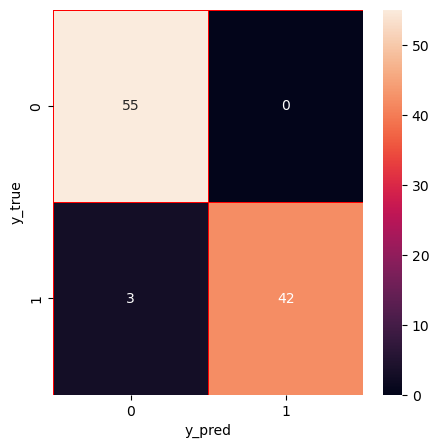


 comparison between label and prediction: 

prediction:  1 orginal label:  1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  1 orginal label:  1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  1 orginal label:  1
-----------------------
prediction:  -1 orginal label:  1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  -1 orginal label:  -1
-----------------------
prediction:  1 orginal label:  1
-----------------------
prediction:  1 orgin

In [82]:
ipopt_solver_handler_sigmoid(default_x,default_y,x_100,y_100,1,1)

### F1_score is 0.965 and it is similar to svm
#### In this implementation, the threshold is set to 0.5 for sigmoid function, Obviously by analyzing different threshold values and even using the ROC it is possible to achieve better model and better performance evaluation metrics

### Part H

## H - 1) Euclidean_distance 
Euclidean Distance is one of the most commonly used distance metrics. Mathematically it is the square root of the sum of differences between two different data points

### 5 fold cross validation for all permutations 

In [63]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
result_list = []
for k in range(1, 19):
#         print("Current K is: ",k )
        #_____________________________________
        # K1 is test and K2-K3-K4-K5 is train set
        train_set = all_matrix[60:,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[0:60,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        first_F1 = f1_score(y_test, y_pred, average='weighted')
#         print(first_F1)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K2 is test and K1-K3-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:60,:],all_matrix[120:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[60:120,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        second_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K3 is test and K1-K2-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:120,:],all_matrix[180:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[120:180,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        third_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K4 is test and K1-K2-K3-K5 is train set
        train_set = np.vstack((all_matrix[0:180,:],all_matrix[240:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[180:240,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        fourth_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K5 is test and K1-K2-K3-K4 is train set
        train_set = all_matrix[0:240,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[240:300,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        fifth_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        F1_avg = (first_F1 + second_F1 + third_F1 + fourth_F1 + fifth_F1)/5
        print(f'F1_Score where k = {k}: {F1_avg}')
        print("___________________________")
        result_list.append((k,F1_avg))
len(result_list)

F1_Score where k = 1: 0.9498672016085672
___________________________
F1_Score where k = 2: 0.9629509131992086
___________________________
F1_Score where k = 3: 0.9629940592745362
___________________________
F1_Score where k = 4: 0.9627973269934469
___________________________
F1_Score where k = 5: 0.9663544696974465
___________________________
F1_Score where k = 6: 0.9696868644589145
___________________________
F1_Score where k = 7: 0.9696868644589145
___________________________
F1_Score where k = 8: 0.9696868644589145
___________________________
F1_Score where k = 9: 0.9696868644589145
___________________________
F1_Score where k = 10: 0.9696868644589145
___________________________
F1_Score where k = 11: 0.9696868644589145
___________________________
F1_Score where k = 12: 0.9696868644589145
___________________________
F1_Score where k = 13: 0.9663661610682606
___________________________
F1_Score where k = 14: 0.9696868644589145
___________________________
F1_Score where k = 15: 0.9630

18

#### Sorting result based on F1_score

In [64]:
result_list.sort(key = lambda i: i[1],reverse=True)
for i in range(len(result_list)):
    print(f'{i+1}- where K is {result_list[i][0]}, F1_score is {result_list[i][1]} ')
    print("______________________________")
# print(result_list)

1- where K is 6, F1_score is 0.9696868644589145 
______________________________
2- where K is 7, F1_score is 0.9696868644589145 
______________________________
3- where K is 8, F1_score is 0.9696868644589145 
______________________________
4- where K is 9, F1_score is 0.9696868644589145 
______________________________
5- where K is 10, F1_score is 0.9696868644589145 
______________________________
6- where K is 11, F1_score is 0.9696868644589145 
______________________________
7- where K is 12, F1_score is 0.9696868644589145 
______________________________
8- where K is 14, F1_score is 0.9696868644589145 
______________________________
9- where K is 13, F1_score is 0.9663661610682606 
______________________________
10- where K is 16, F1_score is 0.9663600578590815 
______________________________
11- where K is 5, F1_score is 0.9663544696974465 
______________________________
12- where K is 15, F1_score is 0.9630393544684278 
______________________________
13- where K is 3, F1_score is 

## H - 2) manhattan_distance
Manhattan distance is a distance measure that is calculated by taking the sum of distances between the x and y coordinates. The Manhattan distance is also known as Manhattan length.

### 5 fold cross validation for all permutations 

In [65]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
result_list = []
for k in range(1, 19):
#         print("Current K is: ",k )
        #_____________________________________
        # K1 is test and K2-K3-K4-K5 is train set
        train_set = all_matrix[60:,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[0:60,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=1)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        first_F1 = f1_score(y_test, y_pred, average='weighted')
#         print(first_F1)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K2 is test and K1-K3-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:60,:],all_matrix[120:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[60:120,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=1)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        second_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K3 is test and K1-K2-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:120,:],all_matrix[180:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[120:180,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=1)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        third_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K4 is test and K1-K2-K3-K5 is train set
        train_set = np.vstack((all_matrix[0:180,:],all_matrix[240:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[180:240,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=1)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        fourth_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K5 is test and K1-K2-K3-K4 is train set
        train_set = all_matrix[0:240,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[240:300,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=1)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        fifth_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        F1_avg = (first_F1 + second_F1 + third_F1 + fourth_F1 + fifth_F1)/5
        print(f'F1_Score where k = {k}: {F1_avg}')
        print("___________________________")
        result_list.append((k,F1_avg))
len(result_list)

F1_Score where k = 1: 0.9465119317329844
___________________________
F1_Score where k = 2: 0.9629509131992086
___________________________
F1_Score where k = 3: 0.9630276630976136
___________________________
F1_Score where k = 4: 0.9627973269934469
___________________________
F1_Score where k = 5: 0.9696868644589145
___________________________
F1_Score where k = 6: 0.9696868644589145
___________________________
F1_Score where k = 7: 0.9696868644589145
___________________________
F1_Score where k = 8: 0.9661577374163575
___________________________
F1_Score where k = 9: 0.9628309308165244
___________________________
F1_Score where k = 10: 0.9661577374163575
___________________________
F1_Score where k = 11: 0.9663600578590815
___________________________
F1_Score where k = 12: 0.9661577374163575
___________________________
F1_Score where k = 13: 0.9628402236072702
___________________________
F1_Score where k = 14: 0.9628309308165244
___________________________
F1_Score where k = 15: 0.9529

18

In [66]:
result_list.sort(key = lambda i: i[1],reverse=True)
for i in range(len(result_list)):
    print(f'{i+1}- where K is {result_list[i][0]}, F1_score is {result_list[i][1]} ')
    print("______________________________")
# print(result_list)

1- where K is 5, F1_score is 0.9696868644589145 
______________________________
2- where K is 6, F1_score is 0.9696868644589145 
______________________________
3- where K is 7, F1_score is 0.9696868644589145 
______________________________
4- where K is 11, F1_score is 0.9663600578590815 
______________________________
5- where K is 8, F1_score is 0.9661577374163575 
______________________________
6- where K is 10, F1_score is 0.9661577374163575 
______________________________
7- where K is 12, F1_score is 0.9661577374163575 
______________________________
8- where K is 3, F1_score is 0.9630276630976136 
______________________________
9- where K is 2, F1_score is 0.9629509131992086 
______________________________
10- where K is 13, F1_score is 0.9628402236072702 
______________________________
11- where K is 9, F1_score is 0.9628309308165244 
______________________________
12- where K is 14, F1_score is 0.9628309308165244 
______________________________
13- where K is 4, F1_score is 0.

## H - 3) minkowski_distance
Minkowski distance is a distance/ similarity measurement between two points in the normed vector space (N dimensional real space) and is a generalization of the Euclidean distance and the Manhattan distance. Table of contents: Minkowski distance in N-D space.

### 5 fold cross validation for all permutations 

In [67]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
result_list = []
for k in range(1, 19):
#         print("Current K is: ",k )
        #_____________________________________
        # K1 is test and K2-K3-K4-K5 is train set
        train_set = all_matrix[60:,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[0:60,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=10)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        first_F1 = f1_score(y_test, y_pred, average='weighted')
#         print(first_F1)
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K2 is test and K1-K3-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:60,:],all_matrix[120:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[60:120,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=10)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        second_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K3 is test and K1-K2-K4-K5 is train set
        train_set = np.vstack((all_matrix[0:120,:],all_matrix[180:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[120:180,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=10)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        third_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K4 is test and K1-K2-K3-K5 is train set
        train_set = np.vstack((all_matrix[0:180,:],all_matrix[240:300,:]))
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[180:240,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=10)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        fourth_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        # K5 is test and K1-K2-K3-K4 is train set
        train_set = all_matrix[0:240,:]
        x_train = train_set[:,0:2]
        y_train = train_set[:,2]
        #_____________________________________
        test_set = all_matrix[240:300,:]
        x_test = test_set[:,0:2]
        y_test = test_set[:,2]
        knn=KNeighborsClassifier(n_neighbors=k, weights='uniform',p=10)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        fifth_F1 = f1_score(y_test, y_pred, average='weighted')
        #_______________________________________________________________________________
        #_______________________________________________________________________________
        F1_avg = (first_F1 + second_F1 + third_F1 + fourth_F1 + fifth_F1)/5
        print(f'F1_Score where k = {k}: {F1_avg}')
        print("___________________________")
        result_list.append((k,F1_avg))
len(result_list)

F1_Score where k = 1: 0.9464302416937039
___________________________
F1_Score where k = 2: 0.9595390839786836
___________________________
F1_Score where k = 3: 0.9663264540360041
___________________________
F1_Score where k = 4: 0.9627973269934469
___________________________
F1_Score where k = 5: 0.9663544696974465
___________________________
F1_Score where k = 6: 0.9661577374163575
___________________________
F1_Score where k = 7: 0.9696868644589145
___________________________
F1_Score where k = 8: 0.9696868644589145
___________________________
F1_Score where k = 9: 0.9696868644589145
___________________________
F1_Score where k = 10: 0.9696868644589145
___________________________
F1_Score where k = 11: 0.9696868644589145
___________________________
F1_Score where k = 12: 0.9663264540360041
___________________________
F1_Score where k = 13: 0.9630691480038058
___________________________
F1_Score where k = 14: 0.9561925638321634
___________________________
F1_Score where k = 15: 0.9529

18

In [68]:
result_list.sort(key = lambda i: i[1],reverse=True)
for i in range(len(result_list)):
    print(f'{i+1}- where K is {result_list[i][0]}, F1_score is {result_list[i][1]} ')
    print("______________________________")
# print(result_list)

1- where K is 7, F1_score is 0.9696868644589145 
______________________________
2- where K is 8, F1_score is 0.9696868644589145 
______________________________
3- where K is 9, F1_score is 0.9696868644589145 
______________________________
4- where K is 10, F1_score is 0.9696868644589145 
______________________________
5- where K is 11, F1_score is 0.9696868644589145 
______________________________
6- where K is 5, F1_score is 0.9663544696974465 
______________________________
7- where K is 3, F1_score is 0.9663264540360041 
______________________________
8- where K is 12, F1_score is 0.9663264540360041 
______________________________
9- where K is 6, F1_score is 0.9661577374163575 
______________________________
10- where K is 13, F1_score is 0.9630691480038058 
______________________________
11- where K is 4, F1_score is 0.9627973269934469 
______________________________
12- where K is 2, F1_score is 0.9595390839786836 
______________________________
13- where K is 16, F1_score is 0.

## H - Results for different distance metrics:
* Minkowski_distance: where K is 7, F1_score is 0.9696868644589145 
* Manhattan_distance: where K is 5, F1_score is 0.9696868644589145 
* Euclidean_distance: where K is 6, F1_score is 0.9696868644589145 

### The remarkable point in this part is the uniqueness of the optimal F1_score and the different value of the optimal k in different distance metrics.

### Part i

____________________________________________________________
Performance evaluation: 
Accuracy:  0.97
Recall:  0.9333333333333333
Precision:  1.0
F1_score:  0.9655172413793104
____________________________________________________________


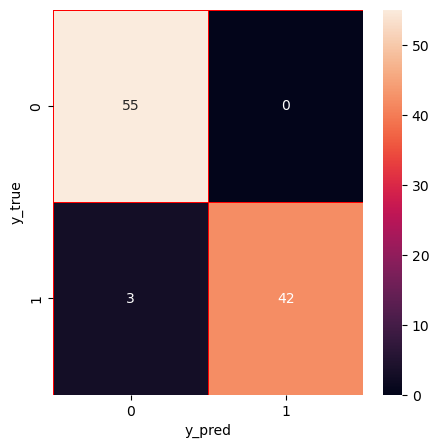

<AxesSubplot:>

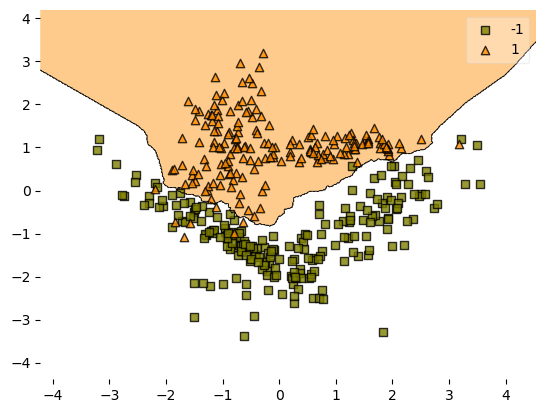

In [78]:
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns 

knn=KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn.fit(x_300,y_300)
y_pred=knn.predict(x_100)
print("____________________________________________________________")
print("Performance evaluation: ")
print("Accuracy: ",accuracy_score(y_100, y_pred))
print("Recall: ",recall_score(y_100, y_pred,))
print("Precision: ",precision_score(y_100, y_pred))
print("F1_score: ",f1_score(y_100, y_pred))
confusion = confusion_matrix(y_100, y_pred)
print("____________________________________________________________")

f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(confusion,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

plot_decision_regions(all_data_x, all_data_y, clf=knn, colors='olive,darkorange')

### Part J

In [97]:
def kernel(x,xp,sigma):
    return np.exp(-np.sum((x-xp)**2)/(2*sigma**2))

def part_i_evaluation(x_trian_values,y_train_values,
                                         x_test_values,y_test_values,c_value,sigma_value):
    
    x_train = x_trian_values
    y_train = y_train_values
    x_test = x_test_values
    y_test = y_test_values
    sigma = sigma_value
    
    gram=np.zeros((len(y_train), len(y_train)))
    for i in range(len(y_train)):
        for ip in range(len(y_train)):
            gram[i,ip]=kernel(x_train[i,:], x_train[ip,:], sigma)
    data_x={(i+1,j+1):x_train[i ,j] for i in range(0, len(y_train)) for j in range(0, x_train.shape[1])}
    data_y={i+1:y_train[i] for i in range(0, len(y_train))}
    dgmodel=pyo.ConcreteModel()
    dgmodel.iset=pyo.Set(initialize=range(1, len(y_train)+1))
    dgmodel.jset=pyo.Set(initialize=range(1,x_train.shape[1]+1))
    dgmodel.x=pyo.Param(dgmodel.iset, dgmodel.jset, initialize=data_x)
    dgmodel.y=pyo.Param(dgmodel.iset, initialize=data_y)
    dgmodel.C=pyo.Param(initialize = c_value, mutable = True)
    dgmodel.alpha=pyo.Var(dgmodel.iset, domain=pyo.NonNegativeReals)
    def dgobj_rule(dgmodel):
        return sum(dgmodel.alpha[i] for i in dgmodel.iset)\
    -0.5*sum(dgmodel.alpha[i]*dgmodel.alpha[ip]*dgmodel.y[i]*dgmodel.y[ip]*gram[i-1,ip-1] for i in dgmodel.iset for ip in dgmodel.iset)
    dgmodel.obj=pyo.Objective(rule=dgobj_rule, sense=pyo.maximize)
    def dgconst1_rule(dgmodel):
        return sum(dgmodel.alpha[i]*dgmodel.y[i] for i in dgmodel.iset)==0
    dgmodel.const1=pyo.Constraint(rule=dgconst1_rule)
    def dgconst2_rule(dgmodel, i):
        return dgmodel.alpha[i]<=dgmodel.C
    dgmodel.const2=pyo.Constraint(dgmodel.iset, rule=dgconst2_rule)
    dgresult = pyo.SolverFactory('ipopt',
                          executable = r"C:\Users\mmmoh\Desktop\Ipopt-3.5.4-win64-icl9.0\Ipopt-3.5.4-win64-icl9.0\bin\ipopt")
    dgresult.solve(dgmodel)
    optimal_alpha_vector = np.array([pyo.value(dgmodel.alpha[i]) for i in dgmodel.iset])
    for i in range(0, len(optimal_alpha_vector)):
        if optimal_alpha_vector[i]>0 and  optimal_alpha_vector[i]<pyo.value(dgmodel.C):
            selected_i=i
            break
    w0=y_train[selected_i]-sum(optimal_alpha_vector[i]*y_train[i]*kernel(
        x_train[i,:], x_train[selected_i,:],sigma) for i in range(len(y_train)))  
    
    yhats_list = []
    for i in range(0, len(y_test)):
        xhat=np.array(x_test[i,:])
        yhat=np.sign(np.array(sum(optimal_alpha_vector[j]*y_train[j]*kernel(
            xhat, x_train[j,:], sigma) for j in range(len(y_train)))+w0))
        yhats_list.append(yhat) 
    tp,fn,fp,tn=[],[],[],[]
    for i in range(len(y_test)):
        if yhats_list[i]==1 and y_test[i]==1:
            tp.append(yhats_list[i])
        if yhats_list[i]==1 and y_test[i]==-1:
            fp.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==1:
            fn.append(yhats_list[i])
        if yhats_list[i]==-1 and y_test[i]==-1:
            tn.append(yhats_list[i])
    if len(tp) == 0 and len(fp) == 0:
        per = 0
        rec = 0
        F1_score = 0
    else:
        per = ((len(tp)) / (len(tp) + len(fp)))
        rec = ((len(tp)) / (len(tp) + len(fn)))
        F1_score = 2*per*rec/(per + rec)
    acc = (len(tp)+len(tn))/(len(tp)+len(tn)+len(fn)+len(fp))
    print("____________________________________________________________")
    print("Performance evaluation for best SVM model: ")
    print("____________________________________________________________")
#     print("True positive rate: ",len(tp) )
#     print("True negative rate: ",len(tn) )
#     print("False positive rate: ",len(fp) )
#     print("False negative rate: ",len(fn) )

    print("Accuracy: ", acc)
    print("Recall: ", rec)
    print("precision: ", per)
    print("F1_Score: ",F1_score )
    print("____________________________________________________________")
    import seaborn as sns 
    confusion = confusion_matrix(y_test, np.array(yhats_list))
    f, ax =plt.subplots(figsize = (5,5))
    sns.heatmap(confusion,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    return yhats_list

____________________________________________________________
Performance evaluation for best SVM model: 
____________________________________________________________
Accuracy:  0.97
Recall:  0.9333333333333333
precision:  1.0
F1_Score:  0.9655172413793104
____________________________________________________________


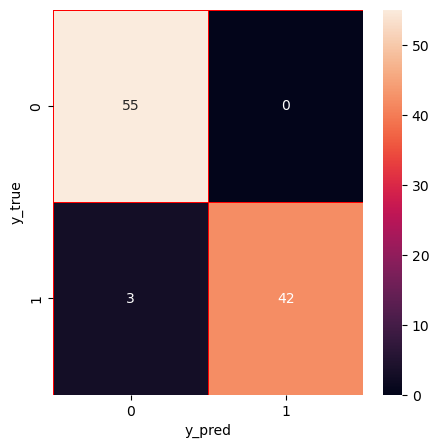

____________________________________________________________
Performance evaluation for best KNN model: 
____________________________________________________________
Accuracy:  0.97
Recall:  0.9333333333333333
Precision:  1.0
F1_score:  0.9655172413793104


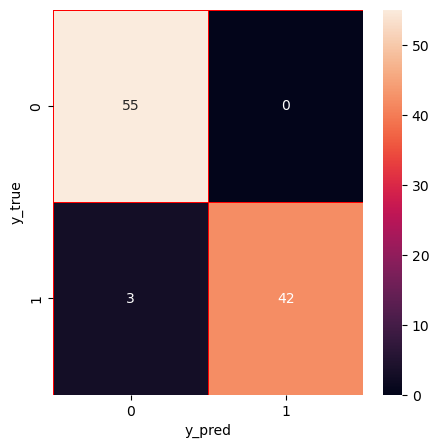

In [98]:
best_svm_model_evaluate = part_i_evaluation(x_300,y_300,x_100,y_100,1,1)
print("____________________________________________________________")
print("Performance evaluation for best KNN model: ")
print("____________________________________________________________")
knn=KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn.fit(x_300,y_300)
y_pred=knn.predict(x_100)
print("Accuracy: ",accuracy_score(y_100, y_pred))
print("Recall: ",recall_score(y_100, y_pred,))
print("Precision: ",precision_score(y_100, y_pred))
print("F1_score: ",f1_score(y_100, y_pred))
confusion = confusion_matrix(y_100, y_pred)

f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(confusion,annot = True, linewidths= 0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### Using the 5-fold corss validation method for KNN and SVM approaches according to the best obtained hyper-parameter gives exactly the same results. Both models have performed well in positive sample classification but they wrongly predict 3 number of negative samples as a of positive data, so this is the weakness that we must try to overcome